## Homework 9: Serverless Deep Learning with AWS Lambda

In this homework, we'll deploy the bees vs wasps model we trained in the 
[previous homework](../08-deep-learning/homework.md).

Download the model from here: 

https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5


In [10]:
#!wget https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import tensorflow.lite as tflite

tf.__version__

'2.9.1'

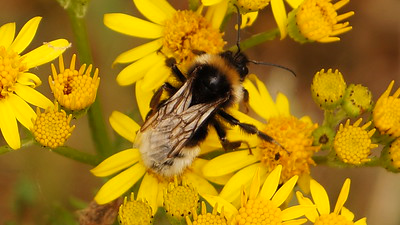

In [2]:
beepath = './21004953130_03d69a5dee_w.jpg'
wasppath= './2088223000_516db96b84_n.jpg'
load_img(beepath)

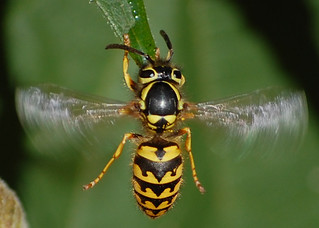

In [3]:
load_img(wasppath)

In [5]:
model = tf.keras.models.load_model('bees-wasps.h5', compile=False)
input_shape = model.input_shape
output_shape = model.output_shape
print("Input shape:", input_shape)
print("Output shape:", output_shape)

Input shape: (None, 150, 150, 3)
Output shape: (None, 1)


In [7]:
def make_array(path, target_tuple):
    img = image.load_img(path, target_size=target_tuple)  # Adjust the target size according to your model's input shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image data
    return img_array

In [8]:
Xbee = make_array(beepath, (150,150))
Xbee.shape

(1, 150, 150, 3)

In [11]:
predictions = model.predict(Xbee)

1/1 [==============================] - 0s 15ms/step


In [12]:
classes = ['bee', 'wasp']
threshold = 0.5

predicted_label = classes[1 if predictions[0] >= threshold else 0]
print("Predicted class:", predicted_label)

Predicted class: bee


In [13]:
Xwasp = make_array(wasppath, (150,150))
predictions = model.predict(Xwasp)
predicted_label = classes[1 if predictions[0] >= threshold else 0]
print("Predicted class:", predicted_label)

1/1 [==============================] - 0s 15ms/step
Predicted class: wasp


## Question 1

Now convert this model from Keras to TF-Lite format.

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('bee-wasp.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0iqkv5b3/assets


INFO:tensorflow:Assets written to: /tmp/tmp0iqkv5b3/assets
2023-11-29 19:29:13.557035: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-11-29 19:29:13.557070: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-11-29 19:29:13.557779: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp0iqkv5b3
2023-11-29 19:29:13.558986: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-11-29 19:29:13.559011: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmp0iqkv5b3
2023-11-29 19:29:13.562697: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-11-29 19:29:13.563374: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-11-29 19:29:13.601637: I tensorflow/cc/saved_model/loader.cc:212] Running initializatio

In [15]:
!ls -lh

total 129M
-rw-rw-r-- 1 jovyan jovyan 251K Nov 29 19:26 09-serverless-lambda.ipynb
-rw-rw-r-- 1 jovyan jovyan  25K Nov 29 19:02 2088223000_516db96b84_n.jpg
-rw-rw-r-- 1 jovyan jovyan  37K Nov 29 19:02 21004953130_03d69a5dee_w.jpg
-rw-rw-r-- 1 jovyan jovyan  86M Nov 29 19:26 bees-wasps.h5
-rw-r--r-- 1 jovyan jovyan  43M Nov 29 19:29 bee-wasp.tflite
-rw-rw-r-- 1 jovyan jovyan   58 Nov 29 19:06 README.md


What's the size of the **converted** model?

* 21 Mb
* 43 Mb  <--
* 80 Mb
* 164 Mb

## Question 2

To be able to use this model, we need to know the index of the input and 
the index of the output. 

In [16]:
interpreter = tflite.Interpreter(model_path='bee-wasp.tflite')
interpreter.allocate_tensors()

interpreter.get_input_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([  1, 150, 150,   3], dtype=int32),
  'shape_signature': array([ -1, 150, 150,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [17]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 13,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

What's the output index for this model?

* 3
* 7
* 13  <--
* 24

## Preparing the image

We'll need some code for downloading and resizing images.

In [18]:
!pip install pillow

In [19]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

Let's download and resize this image: 

https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

Based on the previous testing(and homework 8) , the target size for the image should be (150, 150).

In [20]:
url = 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'
image = download_image(url)

In [21]:
image = prepare_image(image, (150, 150))

/tmp/ipykernel_123/2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


## Question 3

Now we need to turn the image into numpy array and pre-process it. 

In [22]:
def make_X_array(img):
    x_array = np.array(img, dtype='float32')
    X_array = np.array([x_array])
    X_array = X_array / 255.0
    return X_array

In [23]:
X = make_X_array(image)

In [24]:
X.shape

(1, 150, 150, 3)

In [25]:
X[0,0,0,0]

0.94509804

After the pre-processing, what's the value in the first pixel, the R channel?

* 0.3450980
* 0.5450980
* 0.7450980
* 0.9450980  <--

## Question 4

Now let's apply this model to this image. What's the output of the model?

* 0.258
* 0.458
* 0.658  <--
* 0.858

In [26]:
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [27]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

In [28]:
preds = interpreter.get_tensor(output_index)
preds

array([[0.65898407]], dtype=float32)

In [29]:
predicted_label = classes[1 if preds[0] >= threshold else 0]
print("Predicted class:", predicted_label)

Predicted class: wasp


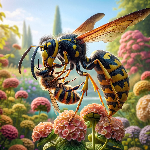

In [30]:
image

## Prepare the lambda code 

Now you need to copy all the code into a separate python file. You will 
need to use this file for the next two questions.

Tip: you can test this file locally with `ipython` or Jupyter Notebook 
by importing the file and invoking the function from this file.  


In [10]:
#!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

In [1]:
import numpy as np
import tflite_runtime.interpreter as tflite

In [2]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [3]:
def make_X_array(img):
    x_array = np.array(img, dtype='float32')
    X_array = np.array([x_array])
    X_array = X_array / 255.0
    return X_array

In [4]:
interpreter = tflite.Interpreter(model_path='bee-wasp.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
url = 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'
image = download_image(url)
image = prepare_image(image, (150, 150))
X = make_X_array(image)

/tmp/ipykernel_3219/2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


In [6]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)

In [7]:
classes = ['bee', 'wasp']
threshold = 0.5

predicted_label = classes[1 if preds[0] >= threshold else 0]
print("Predicted class:", predicted_label)

Predicted class: wasp


In [1]:
import serverlessLambda

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
serverlessLambda.predict('https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg')

'wasp'

In [3]:
event = {'url': 'https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg'}
serverlessLambda.lambda_handler(event, None)

{'prediction': 'wasp'}

## Docker 

For the next two questions, we'll use a Docker image that we already 
prepared. This is the Dockerfile that we used for creating the image:

```docker
FROM public.ecr.aws/lambda/python:3.10
COPY bees-wasps-v2.tflite .
```

And pushed it to [`agrigorev/zoomcamp-bees-wasps:v2`](https://hub.docker.com/r/agrigorev/zoomcamp-bees-wasps/tags).

A few notes:

* The image already contains a model and it's not the same model
  as the one we used for questions 1-4.
* The version of Python is 3.10, so you need to use the right wheel for 
  TF-Lite. For Tensorflow 2.14.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.14.0-cp310-cp310-linux_x86_64.whl


## Question 5

Download the base image `agrigorev/zoomcamp-bees-wasps:v2`. You can easily make it by using [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.


So what's the size of this base image?

* 162 Mb
* 362 Mb
* 662 Mb
* 962 Mb

You can get this information when running `docker images` - it'll be in the "SIZE" column.